In [2]:

from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from statsmodels.tsa import stattools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import *

from sklearn.datasets import load_digits
from scipy.io import arff

from sklearn.feature_selection import SelectKBest, chi2

In [3]:


#DATASET de train
dfLTraining = pd.read_csv('BATADAL_dataset03.csv',header=0) #
#DATASET de test non competitif
dfLTrainingAttack = pd.read_csv('BATADAL_dataset04.csv',header=0) #


#Dataset de test competitif (NE PAS FAIRE DE FIT DESSUS) !! 
dfLTest = pd.read_csv('BATADAL_test_dataset.csv',header=0) #
dfLTestLabeled = pd.read_csv('BATADAL_test_dataset_Label.csv',header=0) #
#Dataset de test competitif (NE PAS FAIRE DE FIT DESSUS) !! 



dfLTestLabeled.columns = dfLTraining.columns.values
dfLTrainingAttack.columns = dfLTraining.columns.values
dfLTest.columns = dfLTraining.columns.values[:-1]

In [4]:
#on regarde le nombre de attaque/ non attaque dans les dataSets

print('répartition attaque pour dfLTraining :\n ',pd.Series(dfLTraining['ATT_FLAG']).value_counts())
print('\n\n')
print('répartition attaque pour dfLTrainingAttack :\n ',pd.Series(dfLTrainingAttack['ATT_FLAG']).value_counts())

#print('répartition attaque pour dfLTest : ',pd.Series(dfLTest['ATT_FLAG']).value_counts())

print('\n\n')
print('répartition attaque pour dfLTestAttack :\n ',pd.Series(dfLTestLabeled['ATT_FLAG']).value_counts())



répartition attaque pour dfLTraining :
  0    8761
Name: ATT_FLAG, dtype: int64



répartition attaque pour dfLTrainingAttack :
  -999    3958
 1       219
Name: ATT_FLAG, dtype: int64



répartition attaque pour dfLTestAttack :
  0.0    1682
1.0     407
Name: ATT_FLAG, dtype: int64


In [5]:
#-999 = normal
#1 = anormal

# => pas très pratique à utiliser, donc on change ca 
dfLTrainingAttack=dfLTrainingAttack.replace({-999: 0})
#0 = normal
#1 = anormal

In [6]:
#valeurs Nan

In [7]:
print(dfLTraining.isnull().sum(axis = 0).any())
print(dfLTrainingAttack.isnull().sum(axis = 0).any())
print(dfLTest.isnull().sum(axis = 0).any())
print(dfLTestLabeled.isnull().sum(axis = 0).any())

False
False
False
False


In [8]:
#for c in dfLTraining.columns.values[1:]:
 #   dfLTraining[c] = pd.to_numeric(dfLTraining[c]) 

In [9]:
# check for inf values

print((~np.isfinite(dfLTraining[dfLTraining.columns.values[1:]]).all()).any()) 
print((~np.isfinite(dfLTrainingAttack[dfLTrainingAttack.columns.values[1:]]).all()).any())
print((~np.isfinite(dfLTest[dfLTest.columns.values[1:]]).all()).any())
print((~np.isfinite(dfLTestLabeled[dfLTestLabeled.columns.values[1:]]).all()).any())

False
False
False
False


In [10]:
#on rassemble le dataset de train et le dataset de test non compétitif contenant des attaques

In [11]:
dfF = pd.concat([dfLTraining,dfLTrainingAttack[dfLTrainingAttack.ATT_FLAG == 1]])

In [10]:
################################################################################################################
################################################################################################################
###################################  sans scaler   #############################################################
################################################################################################################
################################################################################################################

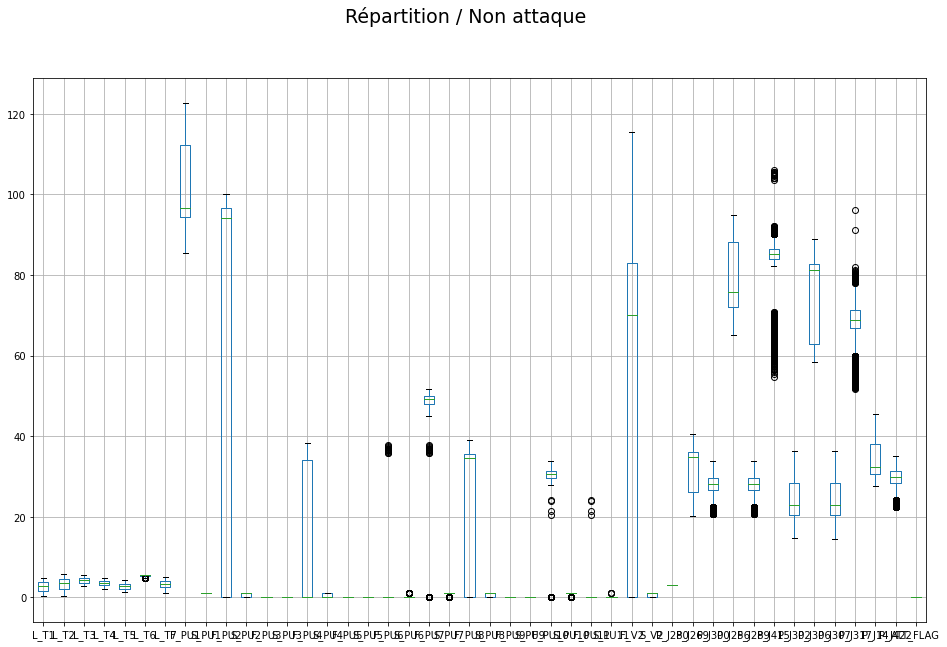

In [11]:
plt.figure(figsize=(16,10))
plt.suptitle('Répartition / Non attaque',fontsize=19)

dfLTraining.drop(dfLTraining.columns.values[0],axis=1).boxplot( )
# des outliers sont présents

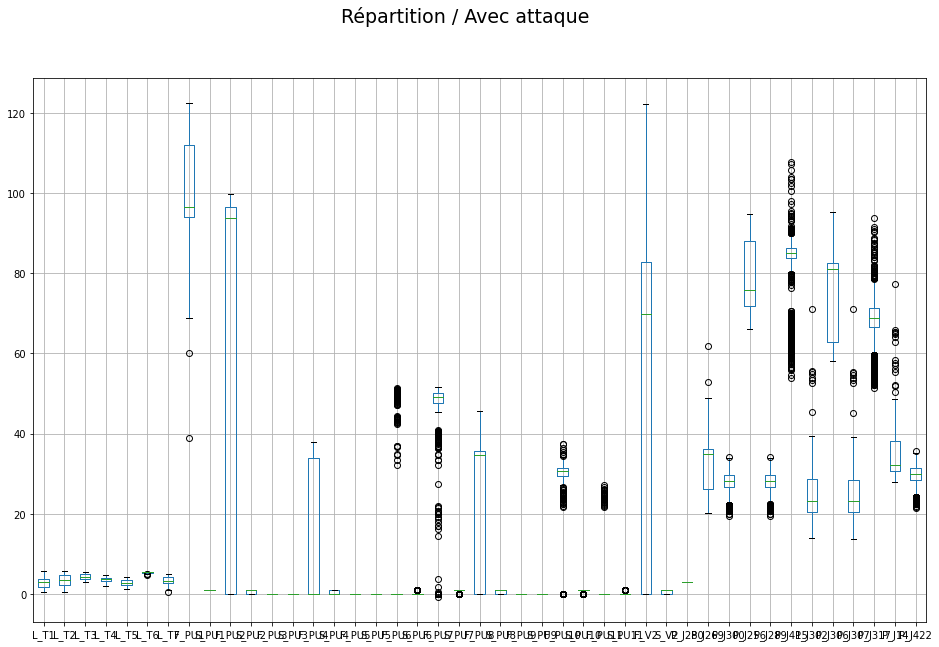

In [12]:
plt.figure(figsize=(16,10))
plt.suptitle('Répartition / Avec attaque',fontsize=19)

dfLTrainingAttack.drop(dfLTrainingAttack.columns.values[0],axis=1).drop(dfLTrainingAttack.columns.values[-1],axis=1).boxplot( )
# des outliers sont présents

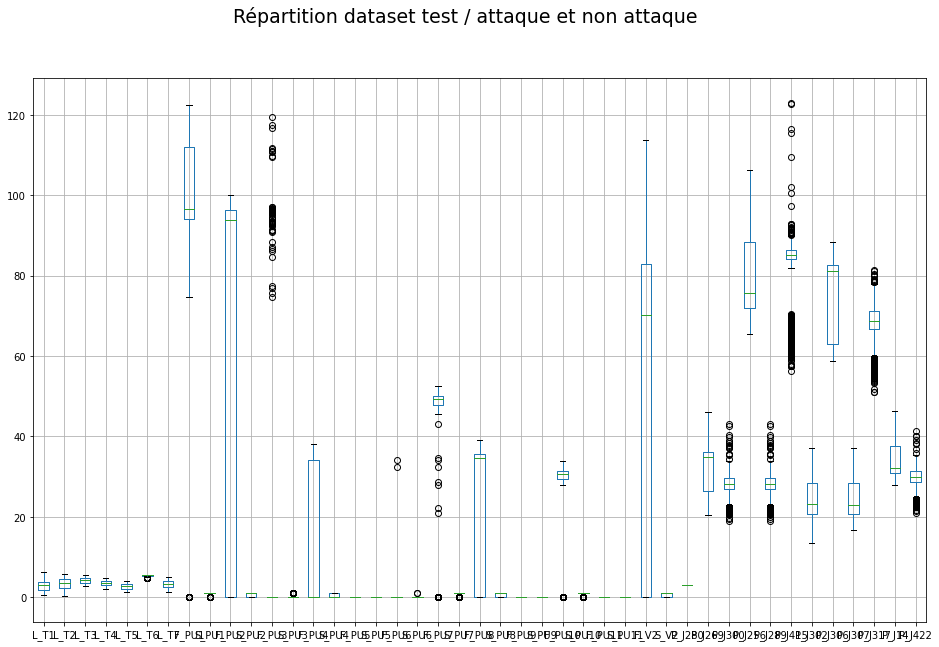

In [13]:
plt.figure(figsize=(16,10))
plt.suptitle('Répartition dataset test / attaque et non attaque',fontsize=19)

dfLTestLabeled.drop(dfLTestLabeled.columns.values[0],axis=1).drop(dfLTestLabeled.columns.values[-1],axis=1).boxplot( )
# des outliers sont présents

In [ ]:
#visualisation de la répartition des valeurs des variables

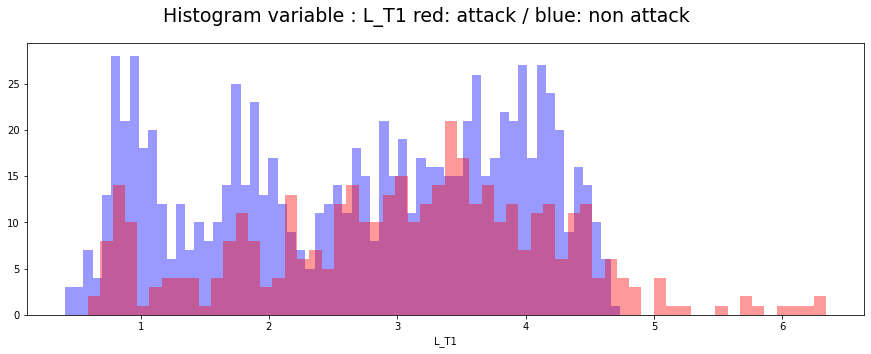

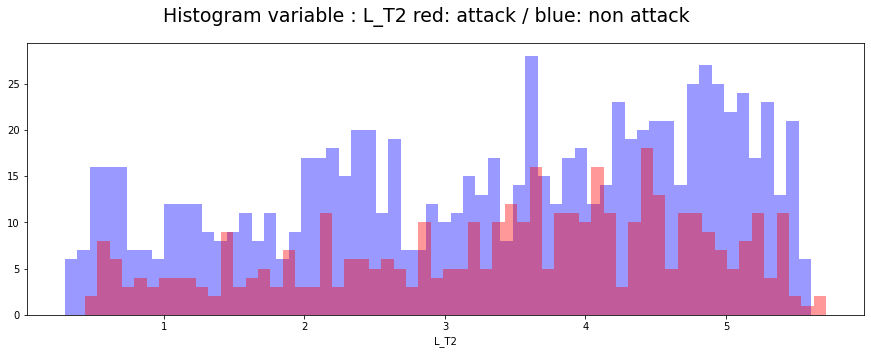

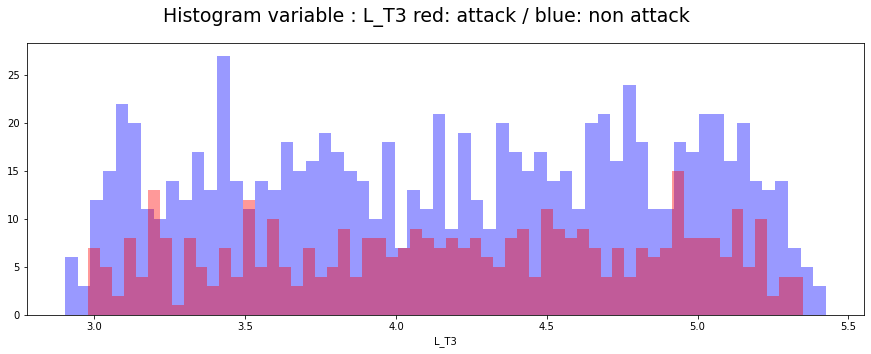

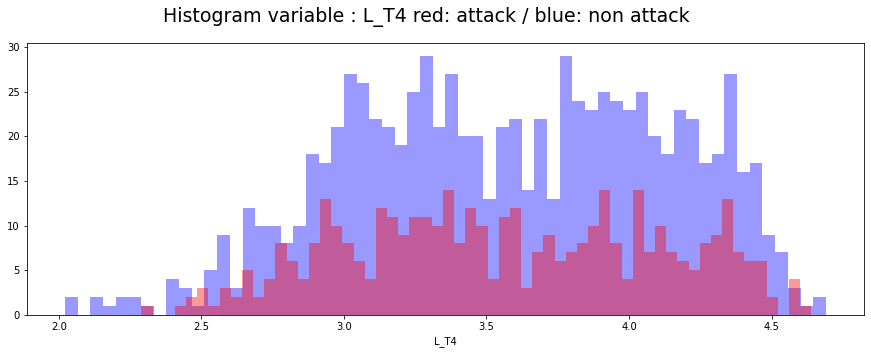

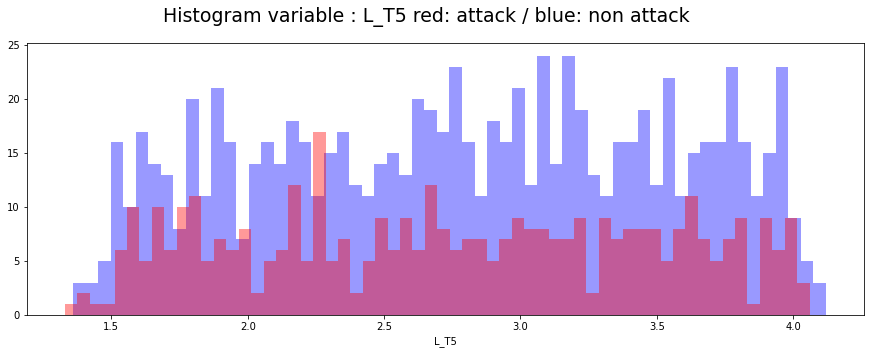

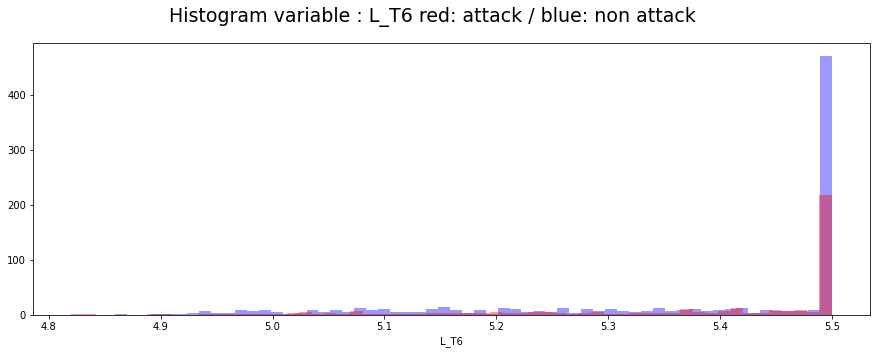

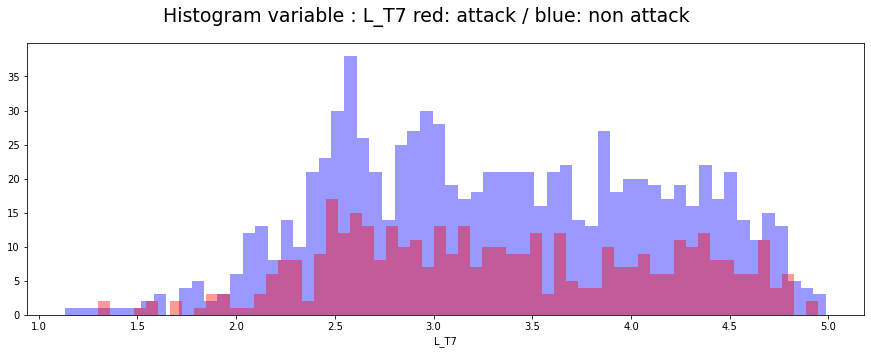

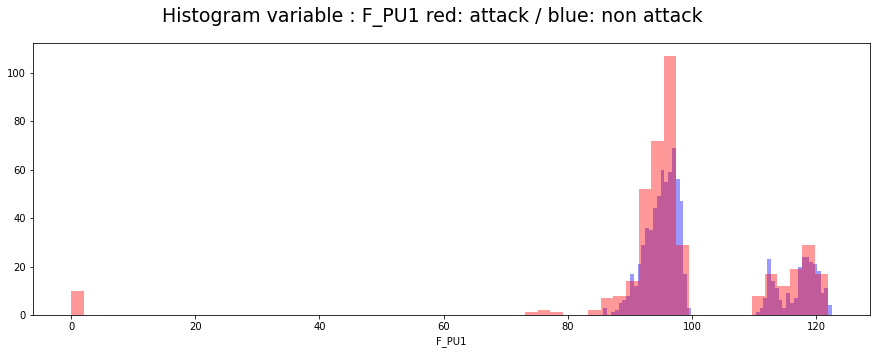

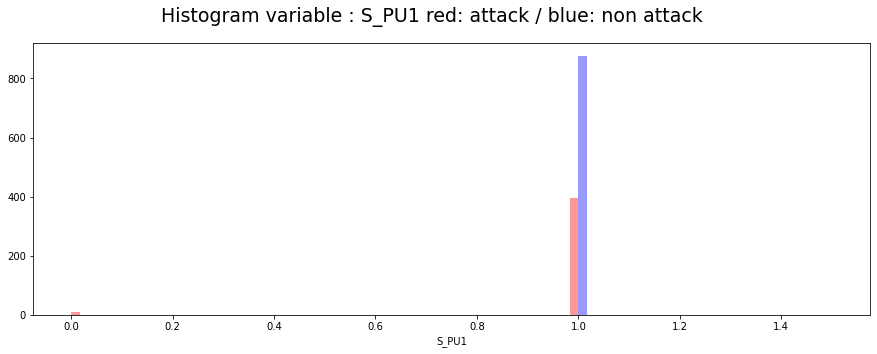

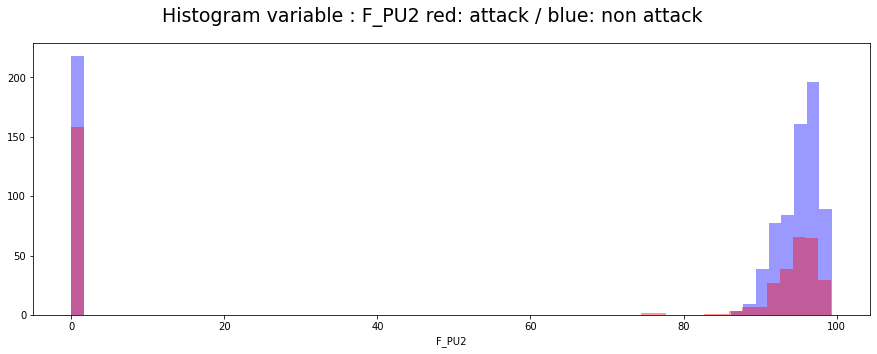

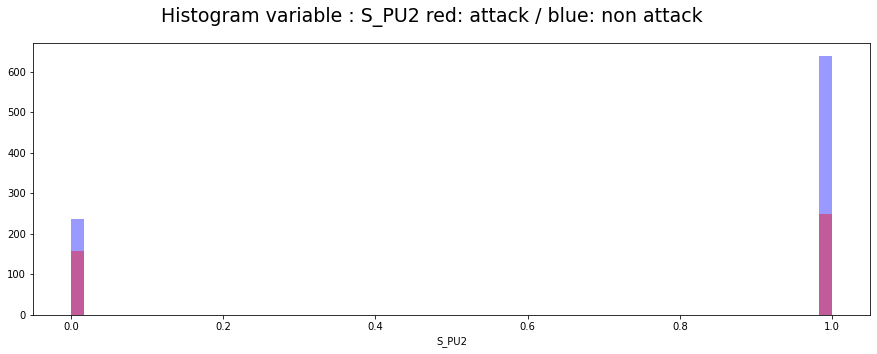

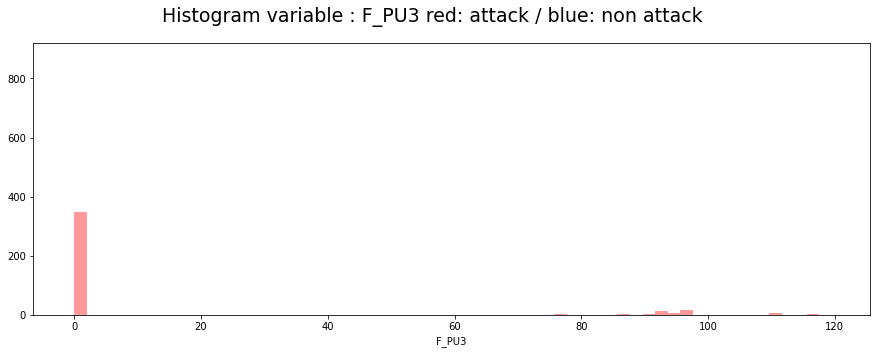

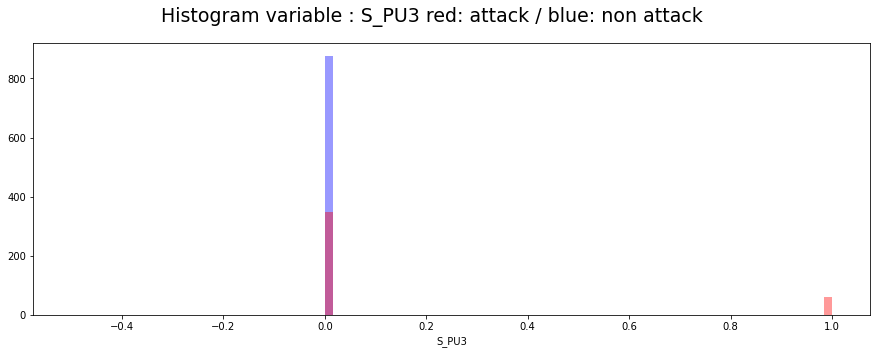

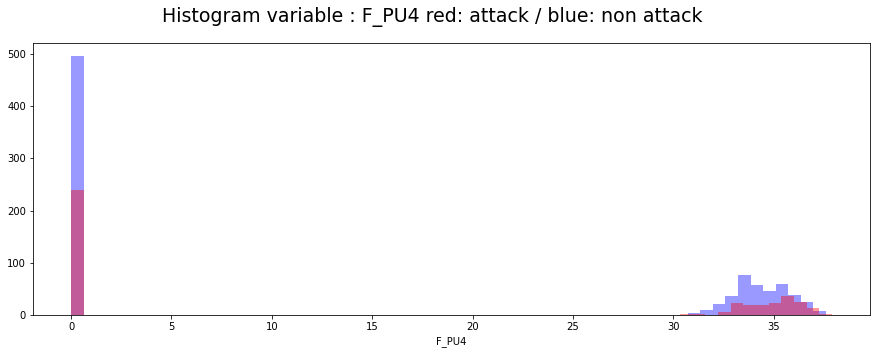

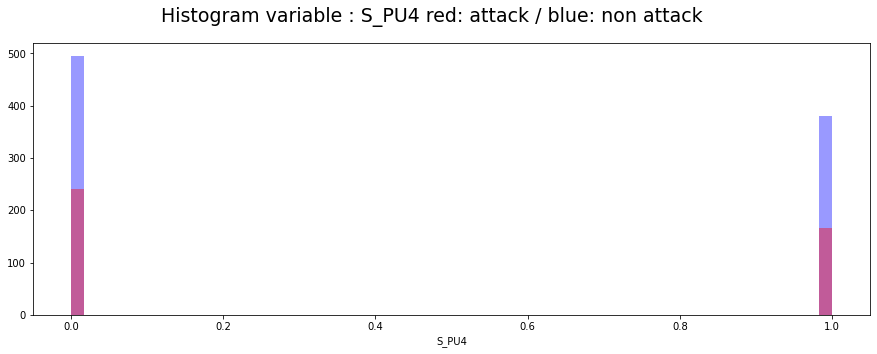

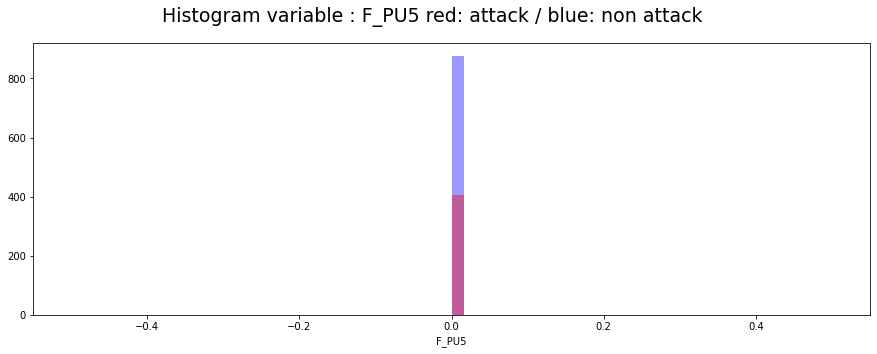

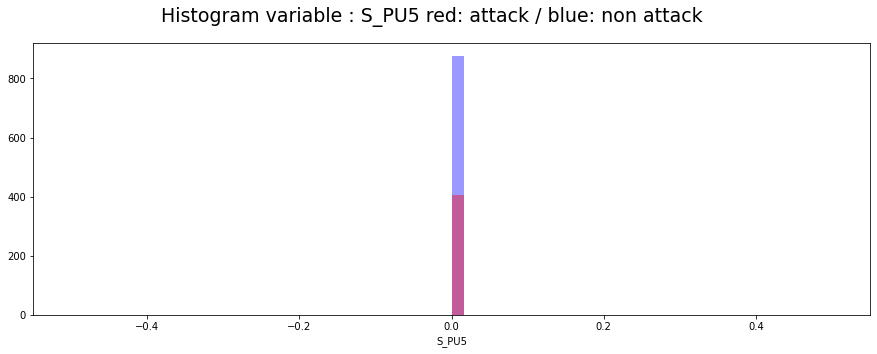

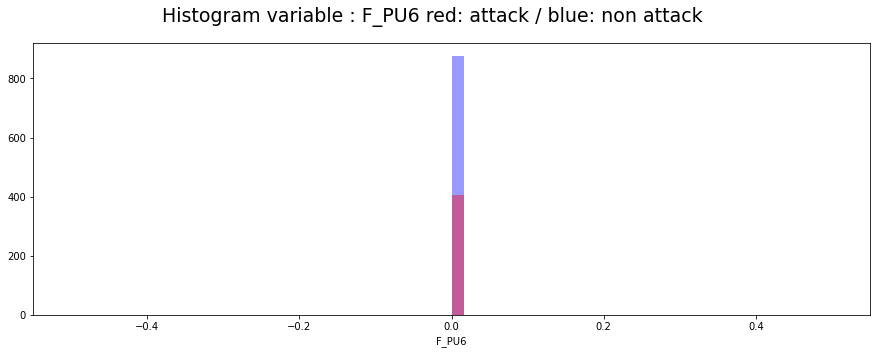

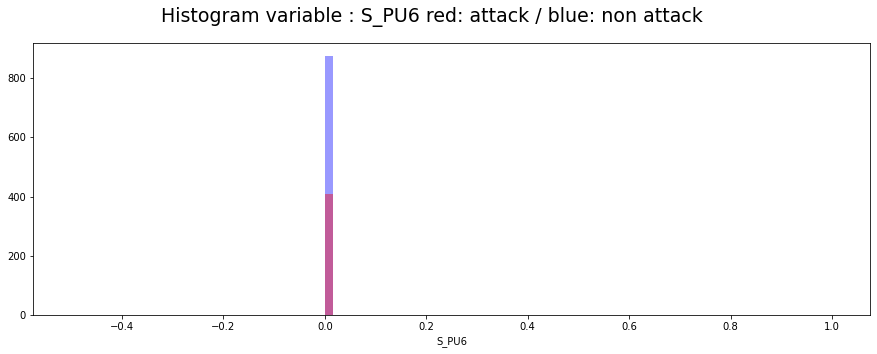

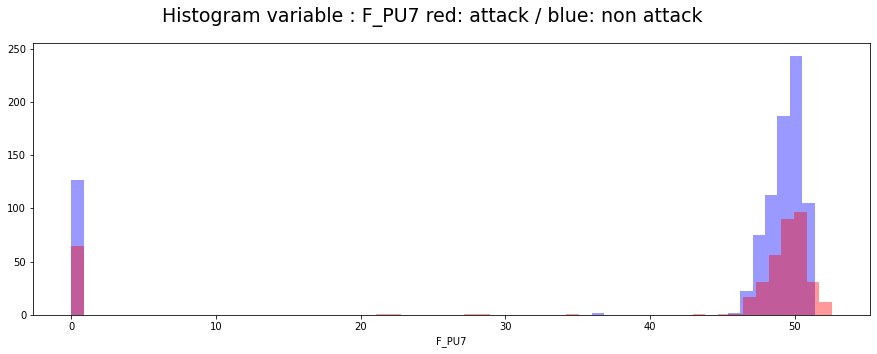

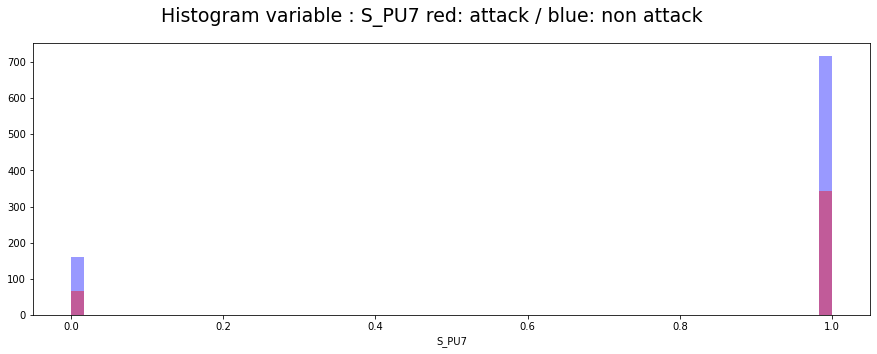

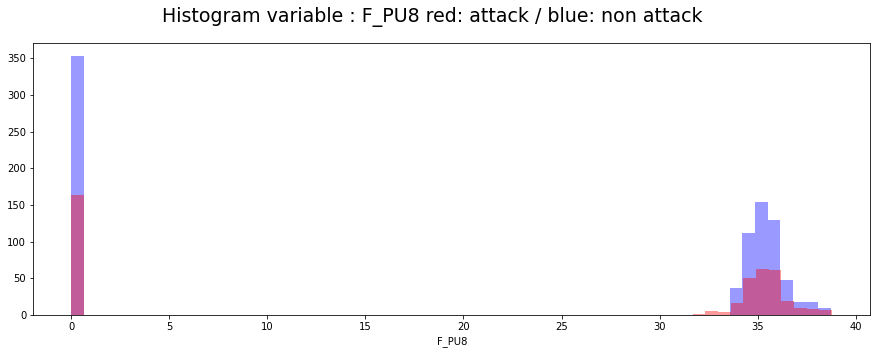

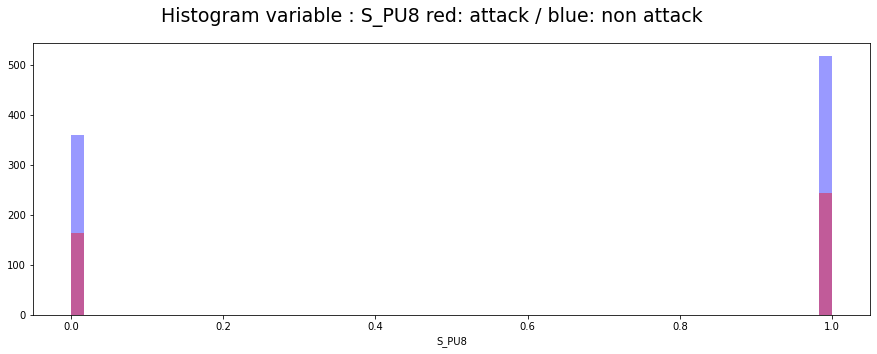

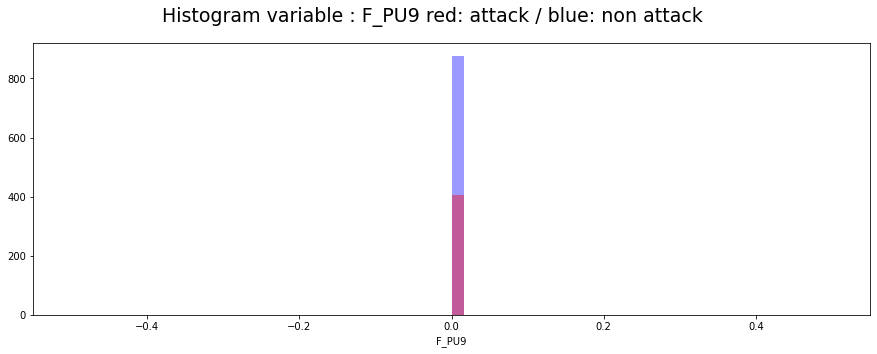

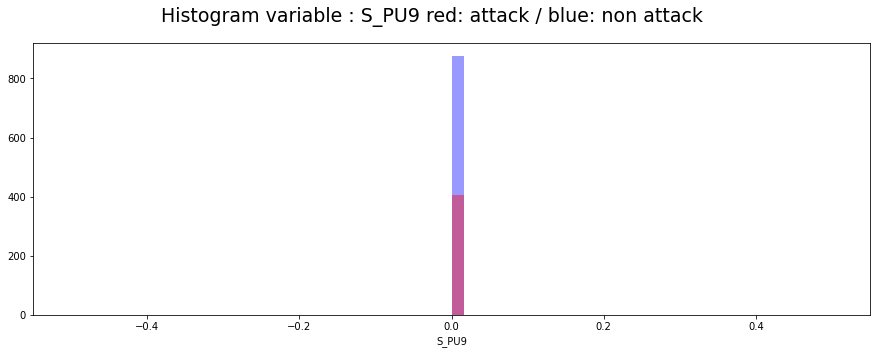

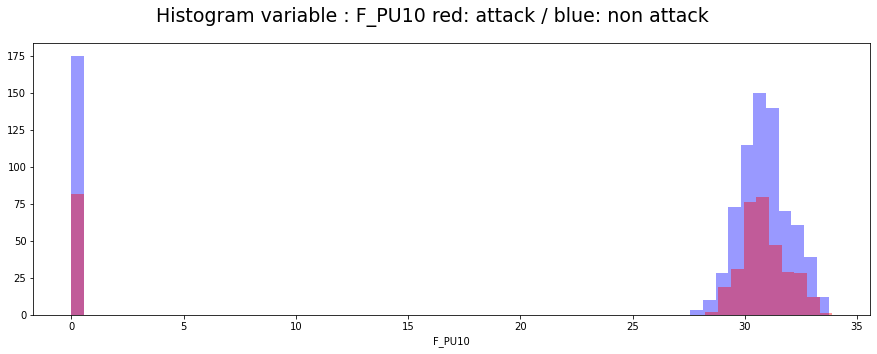

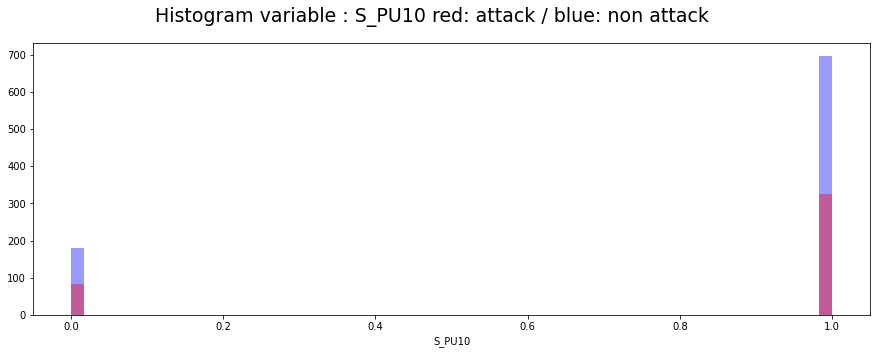

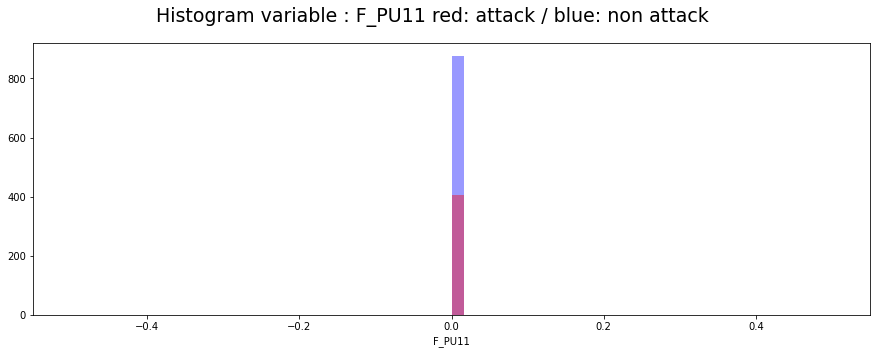

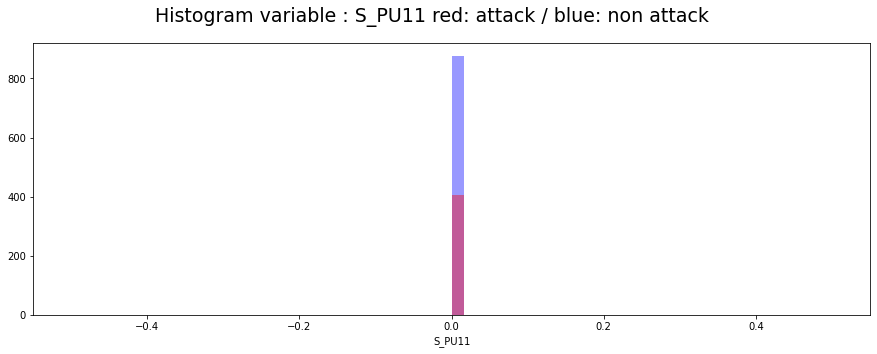

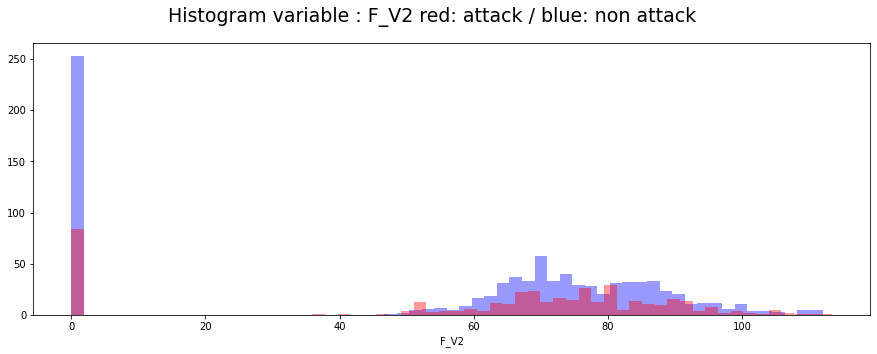

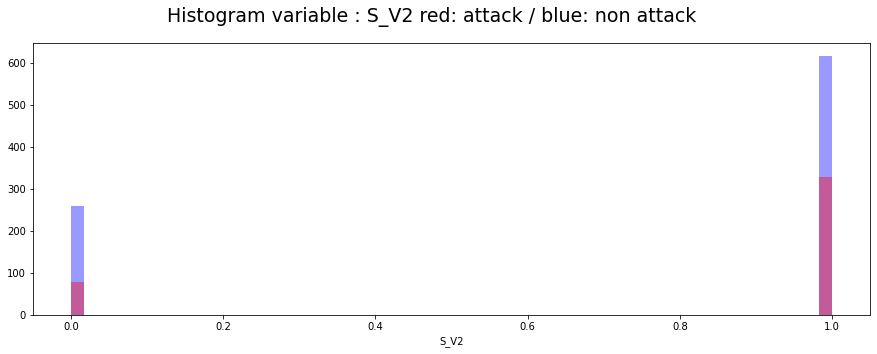

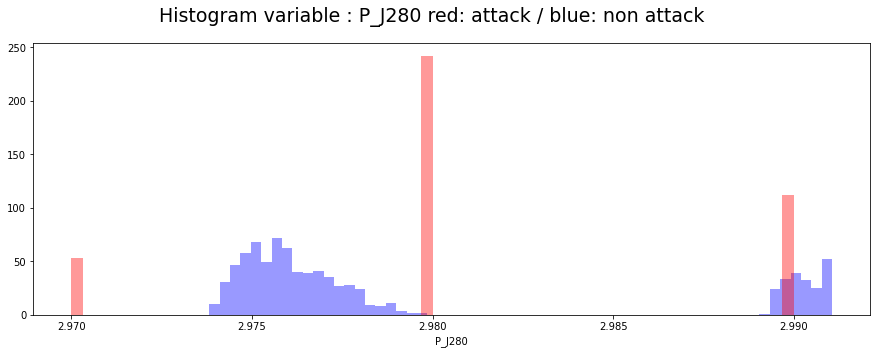

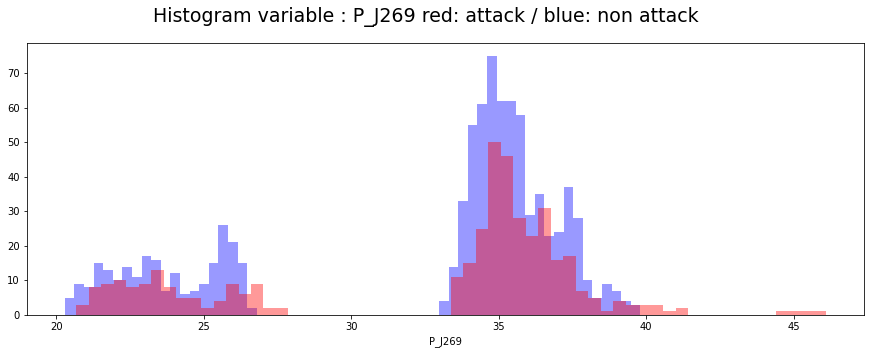

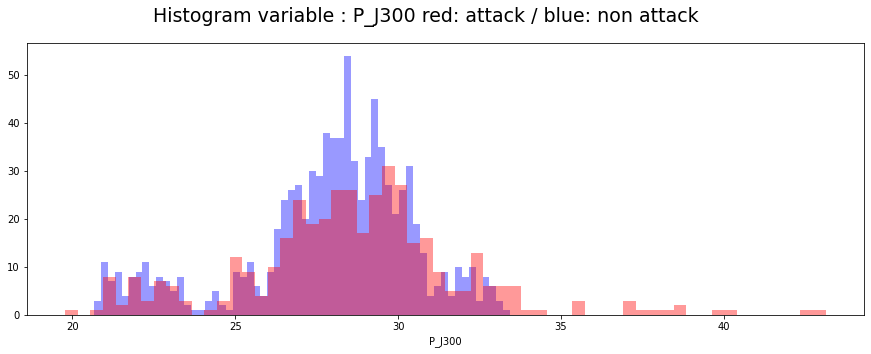

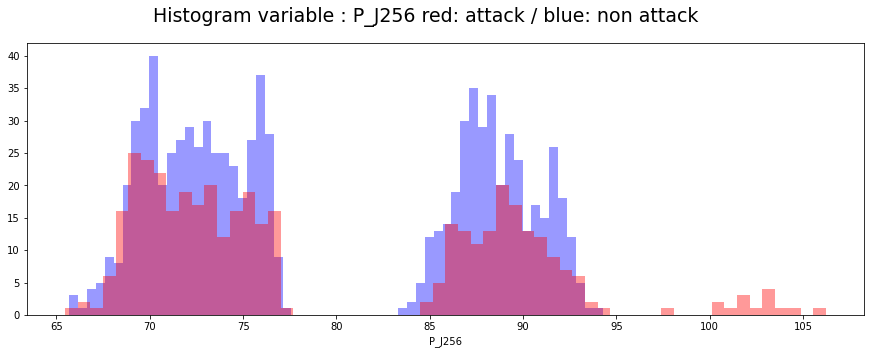

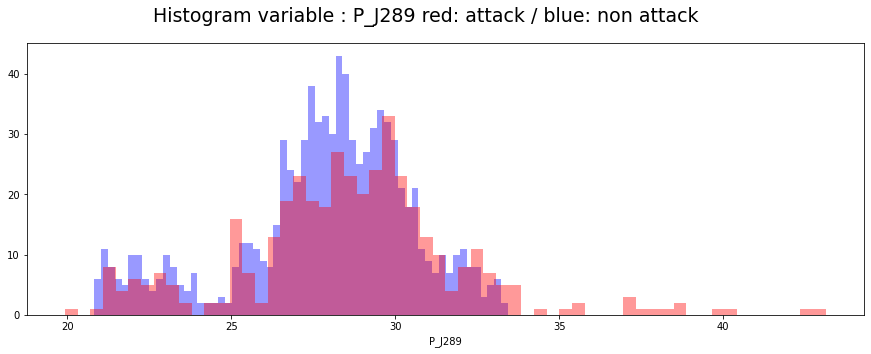

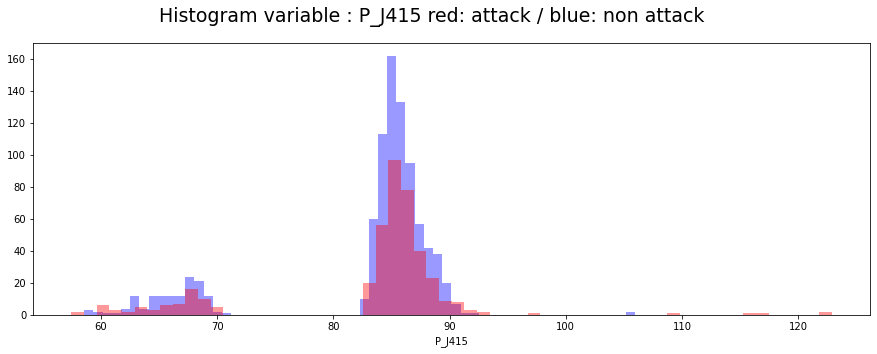

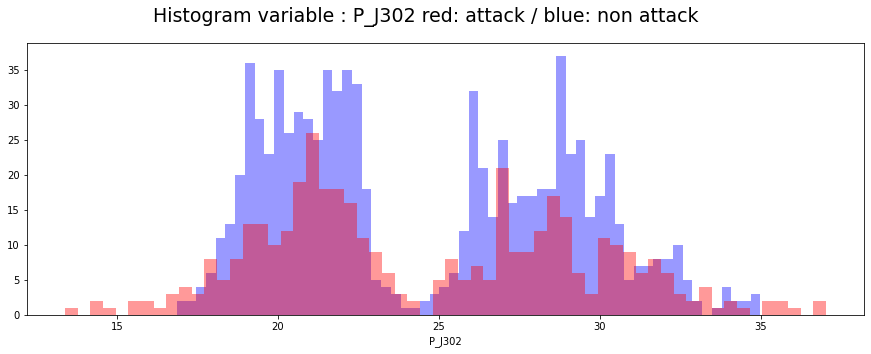

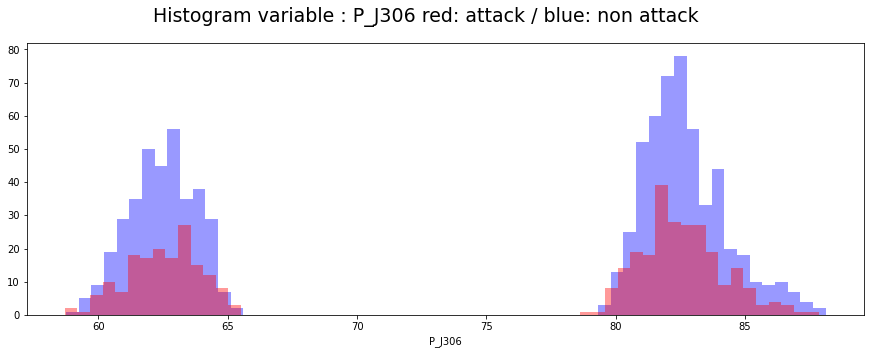

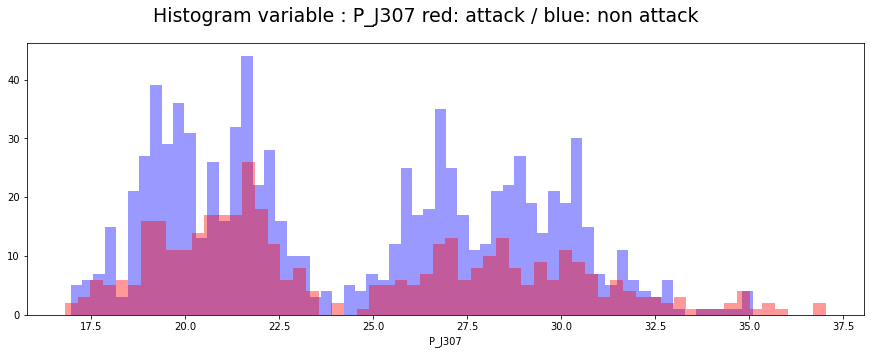

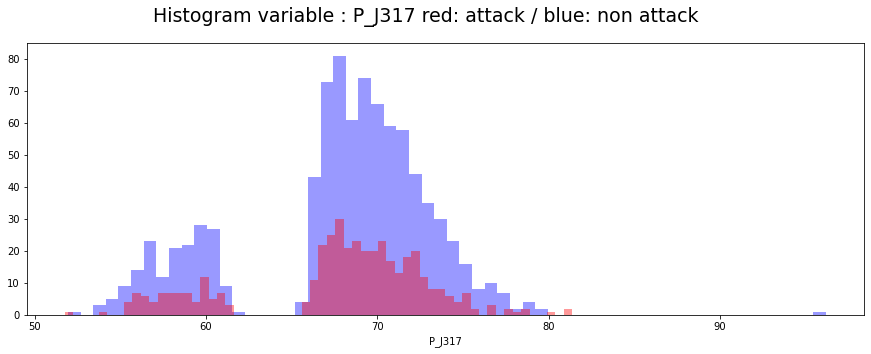

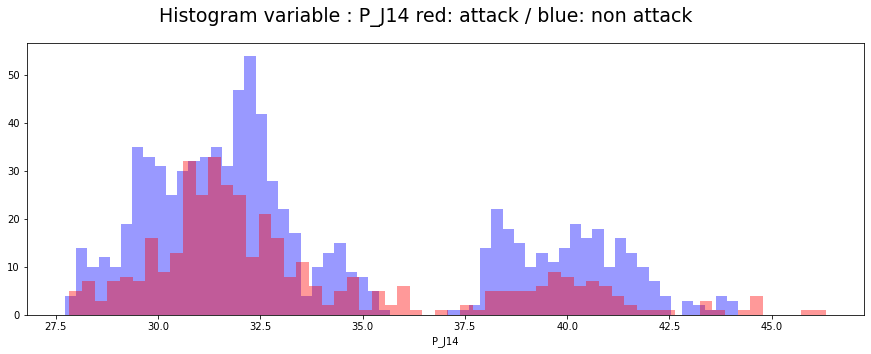

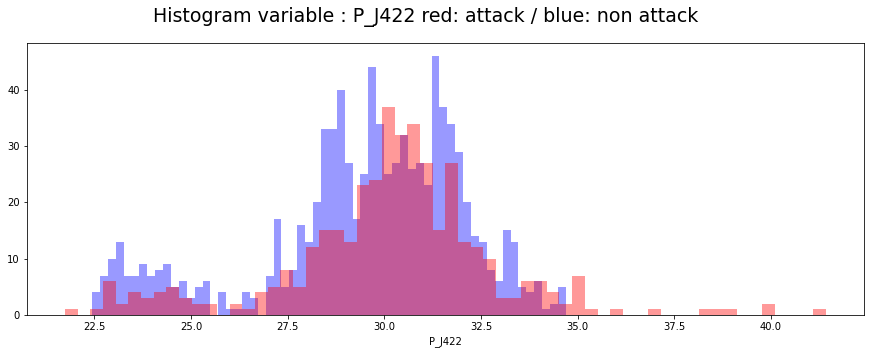

In [22]:
for varname in dfLTraining.columns.values[1:-1]:
    

    plt.figure(figsize=(15,5))
    plt.suptitle('Histogram variable : ' + varname + ' red: attack / blue: non attack  ' ,fontsize=19)
    sns.distplot(dfLTraining[dfLTraining['ATT_FLAG'] == 0 ][varname].sample(frac=0.1),kde=False,bins=60,label='Normal',color='blue')
    sns.distplot(dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 1 ][varname],kde=False,bins=60,label='attack',color='red')

    plt.show()

In [ ]:
#visualisation de la répartition des valeurs des variables

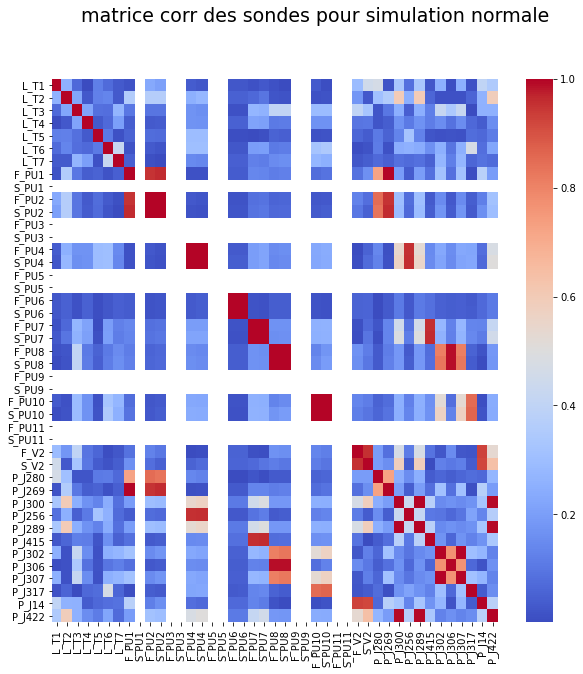

In [23]:

tabcorr=dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 0 ].drop(['DATETIME', 'ATT_FLAG'],axis=1).corr()
plt.figure(figsize=(10,10))
plt.suptitle('matrice corr des sondes pour simulation normale  ',fontsize=19)

sns.heatmap(abs(tabcorr), cmap="coolwarm")
    
plt.show()

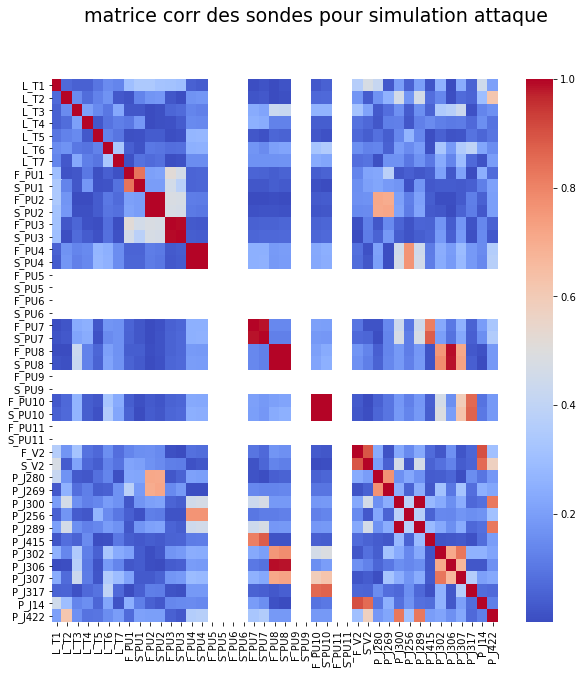

In [24]:

tabcorr=dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 1 ].drop(['DATETIME', 'ATT_FLAG'],axis=1).corr()
plt.figure(figsize=(10,10))
plt.suptitle('matrice corr des sondes pour simulation attaque  ',fontsize=19)

sns.heatmap(abs(tabcorr), cmap="coolwarm")
    
plt.show()

In [ ]:
#il est également difficile de faire la difference entre une attaque et non attaque

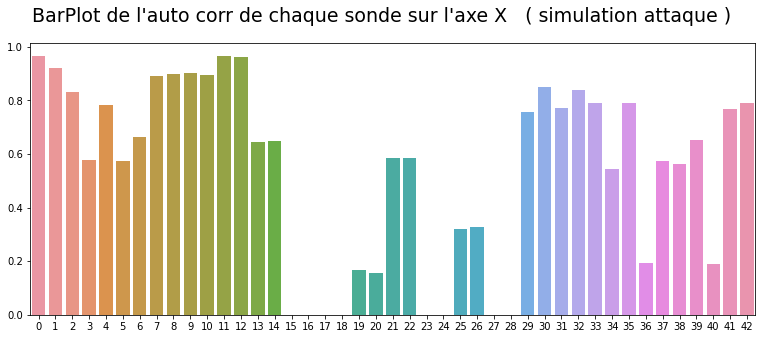

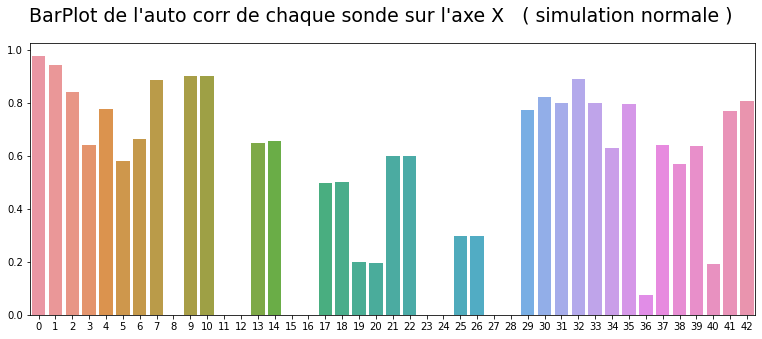

In [12]:
refAttaque = dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 1].drop(['ATT_FLAG'],axis=1)
refNonAttaque = dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 0].drop(['ATT_FLAG'],axis=1)

plt.figure(figsize=(13,5))
arr2 = []
arr = []
for i in dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 0].drop(['DATETIME', 'ATT_FLAG'],axis=1).columns:

    arr2.append(abs(refAttaque[i].autocorr()))
    arr.append(abs(refNonAttaque[i].autocorr()))
    

plt.suptitle('BarPlot de l\'auto corr de chaque sonde sur l\'axe X   ( simulation attaque )' ,fontsize=19)
sns.barplot(np.arange(0,len(arr2)),arr2)
plt.show()
plt.figure(figsize=(13,5))
plt.suptitle('BarPlot de l\'auto corr de chaque sonde sur l\'axe X   ( simulation normale )' ,fontsize=19)
sns.barplot(np.arange(0,len(arr)),arr)
plt.show()

In [ ]:
#pas de grosse diff

Text(0, 0.5, 'Distance ki² entre simulation 1 et 2 ( normales )')

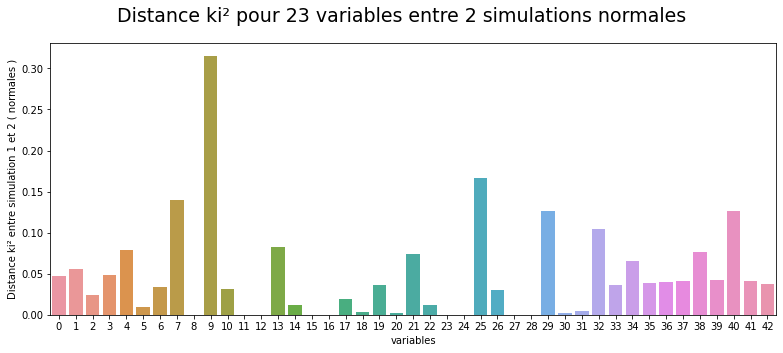

In [13]:
refAttaque = dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 1].drop(['ATT_FLAG'],axis=1)
refNonAttaque = dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 0].drop(['ATT_FLAG'],axis=1)


data_1 = refNonAttaque.sample(frac=0.5)
data_2 = refNonAttaque.drop(data_1.index)

from scipy.stats import energy_distance
distancedistr = []
for sonde in dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 0].drop(['ATT_FLAG','DATETIME'],axis=1).columns:
    distancedistr.append(energy_distance(data_1[sonde],data_2[sonde]))
plt.figure(figsize=(13,5))
sns.barplot(np.arange(0,len(distancedistr)),distancedistr)
plt.suptitle('Distance ki² pour 23 variables entre 2 simulations normales' ,fontsize=19)
plt.xlabel('variables')
plt.ylabel('Distance ki² entre simulation 1 et 2 ( normales )')

Text(0, 0.5, 'Distance ki² entre simulation 1 et 2 ( normales )')

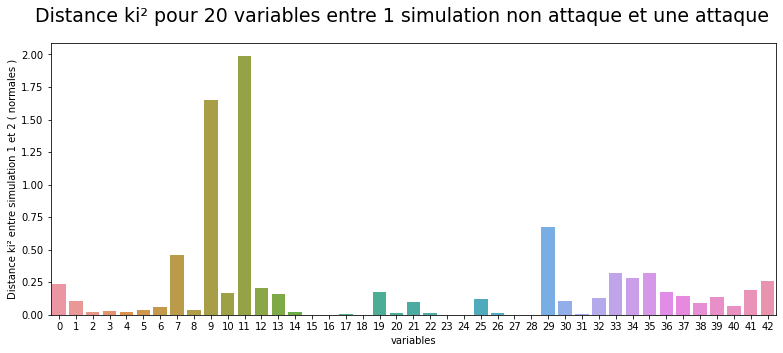

In [14]:
refAttaque = dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 1].drop(['ATT_FLAG'],axis=1)
refNonAttaque = dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 0].drop(['ATT_FLAG'],axis=1)

from scipy.stats import energy_distance
distancedistr = []
for sonde in dfLTestLabeled[dfLTestLabeled['ATT_FLAG'] == 0].drop(['ATT_FLAG','DATETIME'],axis=1).columns:
    distancedistr.append(energy_distance(refNonAttaque[sonde],refAttaque[sonde]))
plt.figure(figsize=(13,5))
sns.barplot(np.arange(0,len(distancedistr)),distancedistr)
plt.suptitle('Distance ki² pour 20 variables entre 1 simulation non attaque et une attaque' ,fontsize=19)
plt.xlabel('variables')
plt.ylabel('Distance ki² entre simulation 1 et 2 ( normales )')

In [ ]:
#la difference est bien présente

In [ ]:
#Pour les algos d'ia Outlier detection, il faut choisir des données pour fit le modele :
#ici on fit notre algo seulement sur le dataset de train, celui-ci ne contient pas d'attaques

In [25]:
################################################## outlier detection

In [26]:
#data_train = dfF[dfF.ATT_FLAG == 0].sample(frac=0.7)
#data_test = dfF[dfF.ATT_FLAG == 0].drop(data_train.index)
#data_testAttack = dfF[dfF.ATT_FLAG == 1]

data_train = dfLTraining

#data_train = dfLTraining
#data_test = dfLTrainingAttack[dfLTrainingAttack.ATT_FLAG == 0]

data_testAttack = dfLTrainingAttack[dfLTrainingAttack.ATT_FLAG == 1]

# dfLTestLabeled[dfLTestLabeled.columns.values[1:]] 

In [27]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, n_jobs=-1 , novelty=True, contamination=0.34,metric='cosine').fit(data_train.drop(['DATETIME', 'ATT_FLAG'],axis=1))


dfLTestLabeledTEMP = pd.DataFrame( dfLTestLabeled.values , columns =dfLTestLabeled.columns.values ) 


res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 0].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs normales   (test set)")
print(pd.Series(res).value_counts())

res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 1].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs Anormales    (test set)")
print(pd.Series(res).value_counts())


prédiction valeurs normales   (test set)
 1    1061
-1     621
dtype: int64
prédiction valeurs Anormales    (test set)
-1    349
 1     58
dtype: int64


In [62]:
#trop de faux positifs
print("detection attaques : ",58/(621+58)-1)
print("detection echants normaux : ",621/(1061+621)-1)

detection attaques :  -0.914580265095729
detection echants normaux :  -0.6307966706302022


In [29]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, n_jobs=-1 , novelty=True, contamination=0.07,metric='cosine').fit(data_train.drop(['DATETIME', 'ATT_FLAG'],axis=1))


dfLTestLabeledTEMP = pd.DataFrame( dfLTestLabeled.values , columns =dfLTestLabeled.columns.values ) 


res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 0].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs normales   (test set)")
print(pd.Series(res).value_counts())

res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 1].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs Anormales    (test set)")
print(pd.Series(res).value_counts())


prédiction valeurs normales   (test set)
 1    1553
-1     129
dtype: int64
prédiction valeurs Anormales    (test set)
-1    259
 1    148
dtype: int64


In [ ]:
#pas mal mais le taux de faux positifs est encore un peu élevé

In [31]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators = 200).fit(data_train.drop(['DATETIME', 'ATT_FLAG'],axis=1))



dfLTestLabeledTEMP = pd.DataFrame( dfLTestLabeled.values , columns =dfLTestLabeled.columns.values ) 


res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 0].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs normales   (test set)")
print(pd.Series(res).value_counts())

res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 1].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs Anormales    (test set)")
print(pd.Series(res).value_counts())

prédiction valeurs normales   (test set)
 1    849
-1    833
dtype: int64
prédiction valeurs Anormales    (test set)
-1    236
 1    171
dtype: int64


In [32]:
#fonctionne pas

In [33]:
from sklearn.svm import OneClassSVM 


clf = OneClassSVM( nu=0.005,verbose=True).fit(data_train.drop(['DATETIME', 'ATT_FLAG'],axis=1))




dfLTestLabeledTEMP = pd.DataFrame( dfLTestLabeled.values , columns =dfLTestLabeled.columns.values ) 


res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 0].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs normales   (test set)")
print(pd.Series(res).value_counts())

res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 1].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs Anormales    (test set)")
print(pd.Series(res).value_counts())

[LibSVM]prédiction valeurs normales   (test set)
 1    1668
-1      14
dtype: int64
prédiction valeurs Anormales    (test set)
 1    332
-1     75
dtype: int64


In [ ]:
#fonctionne pas

In [35]:
from sklearn.svm import OneClassSVM 


clf = OneClassSVM( nu=0.02,verbose=True).fit(data_train.drop(['DATETIME', 'ATT_FLAG'],axis=1))




dfLTestLabeledTEMP = pd.DataFrame( dfLTestLabeled.values , columns =dfLTestLabeled.columns.values ) 


res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 0].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs normales   (test set)")
print(pd.Series(res).value_counts())

res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 1].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs Anormales    (test set)")
print(pd.Series(res).value_counts())

[LibSVM]prédiction valeurs normales   (test set)
 1    1647
-1      35
dtype: int64
prédiction valeurs Anormales    (test set)
 1    324
-1     83
dtype: int64


In [36]:
#fonctionne pas

In [37]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope( contamination=0.05,assume_centered =True).fit(data_train.drop(['DATETIME', 'ATT_FLAG'],axis=1))




dfLTestLabeledTEMP = pd.DataFrame( dfLTestLabeled.values , columns =dfLTestLabeled.columns.values ) 


res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 0].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs normales   (test set)")
print(pd.Series(res).value_counts())

res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 1].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs Anormales    (test set)")
print(pd.Series(res).value_counts())

/home/AI357/.local/lib/python3.6/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


prédiction valeurs normales   (test set)
 1    1596
-1      86
dtype: int64
prédiction valeurs Anormales    (test set)
 1    380
-1     27
dtype: int64


In [38]:
"ne fonctionne pas"

'ne fonctionne pas'

In [39]:
############## on entraîne uniquement sur le dataset test
# en effet, le dataset de test ( NON COMPETITIF ) contient des attaques et des paramètres initiaux differents,
#il peut etre donc interressant de fit le modèle desssus

In [40]:


data_train = dfLTrainingAttack[dfLTrainingAttack.ATT_FLAG == 0]


In [41]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, n_jobs=-1 ,contamination= 0.34, novelty=True,metric='cosine').fit(data_train.drop([ 'DATETIME', 'ATT_FLAG'],axis=1))

dfLTestLabeledTEMP = pd.DataFrame( dfLTestLabeled.values , columns =dfLTestLabeled.columns.values ) 


res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 0].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs normales (test set)")
print(pd.Series(res).value_counts())

res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 1].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs Anormales  (test set)")
print(pd.Series(res).value_counts())


prédiction valeurs normales (test set)
 1    1174
-1     508
dtype: int64
prédiction valeurs Anormales  (test set)
-1    315
 1     92
dtype: int64


In [ ]:
#trop de faux positifs

In [44]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope( contamination=0.1).fit(data_train.drop(['DATETIME', 'ATT_FLAG'],axis=1))



dfLTestLabeledTEMP = pd.DataFrame( dfLTestLabeled.values , columns =dfLTestLabeled.columns.values ) 


res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 0].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs normales (test set)")
print(pd.Series(res).value_counts())

res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 1].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs Anormales  (test set)")
print(pd.Series(res).value_counts())


/home/AI357/.local/lib/python3.6/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


prédiction valeurs normales (test set)
 1    1568
-1     114
dtype: int64
prédiction valeurs Anormales  (test set)
-1    283
 1    124
dtype: int64


In [45]:
145/(145+262)-1

-0.6437346437346437

In [63]:
((100-114/(1568+114)*100)+(100-124/(283+124)*100))/2

81.37776193662043

In [ ]:
#score correct, il faut diminuer les faux positifs

In [47]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope( contamination=0.1,assume_centered=True ).fit(data_train.drop(['DATETIME', 'ATT_FLAG'],axis=1))



dfLTestLabeledTEMP = pd.DataFrame( dfLTestLabeled.values , columns =dfLTestLabeled.columns.values ) 


res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 0].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs normales (test set)")
print(pd.Series(res).value_counts())

res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 1].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs Anormales  (test set)")
print(pd.Series(res).value_counts())


/home/AI357/.local/lib/python3.6/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


prédiction valeurs normales (test set)
 1    1569
-1     113
dtype: int64
prédiction valeurs Anormales  (test set)
-1    283
 1    124
dtype: int64


In [64]:
((100-113/(1569+113)*100)+(100-124/(283+124)*100))/2

81.40748845267275

In [ ]:
#idem

In [49]:
#### fit sur DATASET train et DATASET TEST ( non competitif )
# cette fois ci, on mélange le dataset de train et de test non compétitif

#cela permet d'avoir des données qui ont des paramètres initiaux differents
#sachant que le dataset competitif sur lequelle nous calculons les résultats a des paramètres initiaux differents également

data_train = pd.concat( [ dfLTrainingAttack[dfLTrainingAttack.ATT_FLAG == 0] ,     dfLTraining    ])


In [50]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope( contamination=0.06,assume_centered=True ).fit(data_train.drop(['DATETIME', 'ATT_FLAG'],axis=1))



dfLTestLabeledTEMP = pd.DataFrame( dfLTestLabeled.values , columns =dfLTestLabeled.columns.values ) 


res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 0].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs normales (test set)")
print(pd.Series(res).value_counts())

res = clf.predict(dfLTestLabeledTEMP[dfLTestLabeledTEMP.ATT_FLAG == 1].drop([ 'DATETIME','ATT_FLAG'],axis=1))
print("prédiction valeurs Anormales  (test set)")
print(pd.Series(res).value_counts())


/home/AI357/.local/lib/python3.6/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


prédiction valeurs normales (test set)
 1    1582
-1     100
dtype: int64
prédiction valeurs Anormales  (test set)
-1    281
 1    126
dtype: int64


In [65]:
((100-100/(1582+100)*100)+(100-126/(281+126)*100))/2

81.54823291565265

In [ ]:
#pas mal

In [52]:
#################################################### classification
####### on melange test set (non competitif) et train set 

In [53]:

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn import ensemble

dfF = pd.concat( [ dfLTrainingAttack[dfLTrainingAttack.ATT_FLAG == 1] ,     dfLTraining    ])


data_train = dfF.sample(frac=0.7)
data_test = dfF.drop(data_train.index)


Y_train = data_train['ATT_FLAG'].values
X_train = data_train.drop(['DATETIME', 'ATT_FLAG'],axis=1).values




Y_test = data_test['ATT_FLAG'].values
X_test = data_test.drop(['DATETIME', 'ATT_FLAG'],axis=1).values


#on test sur le dataset de test competitif
Y_dataset_test = dfLTestLabeled['ATT_FLAG'].values
X_dataset_test = dfLTestLabeled.drop(['DATETIME', 'ATT_FLAG'],axis=1).values


print(print(pd.Series(Y_test).value_counts()))

0    2581
1      30
dtype: int64
None


test sur le datset de train
0.9969360398314822
[0.99844901 0.875     ]
test sur le datset de test competition
0.3614169459071326
[0.40232975 0.31449126]


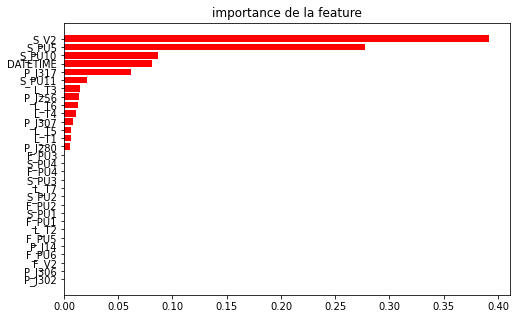

In [54]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
model.fit(X_train,  Y_train)
print("test sur le datset de train")
y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))
importances = model.feature_importances_
indices = np.argsort(importances)[-30:]

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)),importances[indices],color='r',align='center')
plt.yticks(range(len(indices)),dfF.columns[indices])
plt.title("importance de la feature")


print("test sur le datset de test competition")
y_dct = model.predict(X_dataset_test)
print(accuracy_score(Y_dataset_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_dataset_test, y_dct, average=None)) 

test sur le datset de train
0.9980850248946763
[0.99903232 0.90909091]
test sur le datset de test competition
0.49736716132120634
[0.61453744 0.2778542 ]


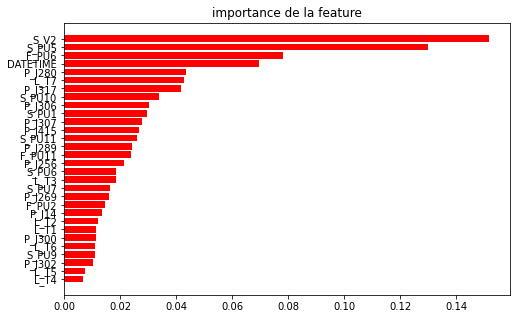

In [55]:
model = ensemble.RandomForestClassifier()

model.fit(X_train,  Y_train)
print("test sur le datset de train")
y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))
importances = model.feature_importances_
indices = np.argsort(importances)[-30:]

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)),importances[indices],color='r',align='center')
plt.yticks(range(len(indices)),dfF.columns[indices])
plt.title("importance de la feature")


print("test sur le datset de test competition")
y_dct = model.predict(X_dataset_test)
print(accuracy_score(Y_dataset_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_dataset_test, y_dct, average=None))

In [56]:
model = ensemble.RandomForestClassifier(n_estimators = 500)

model.fit(X_train,  Y_train)

y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))


print("test sur le datset de test competition")
y_dct = model.predict(X_dataset_test)
print(accuracy_score(Y_dataset_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_dataset_test, y_dct, average=None))

0.9980850248946763
[0.99903195 0.9122807 ]
test sur le datset de test competition
0.5375777884155098
[0.6620014  0.26818182]


In [57]:
model = GradientBoostingClassifier()

model.fit(X_train,  Y_train)

y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))


print("test sur le datset de test competition")
y_dct = model.predict(X_dataset_test)
print(accuracy_score(Y_dataset_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_dataset_test, y_dct, average=None))

0.9988510149368058
[0.99941894 0.94915254]
test sur le datset de test competition
0.3623743417903303
[0.40482574 0.31340206]


In [58]:
model = GradientBoostingClassifier(max_depth = 7)

model.fit(X_train,  Y_train)

y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))



print("test sur le datset de test competition")
y_dct = model.predict(X_dataset_test)
print(accuracy_score(Y_dataset_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_dataset_test, y_dct, average=None))

0.9988510149368058
[0.99941894 0.94915254]
test sur le datset de test competition
0.3585447582575395
[0.40391459 0.30569948]


In [ ]:
#scores nuls